In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scripts.data_loader import load_caravan
from scripts.metrics import evaluate_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, precision_recall_curve

## Evaluation Metrics 

- **ROC-AUC**  
  *How well the model ranks positives vs. negatives.*  
  > Above 0.7 means the model separates classes reasonably well.

- **PR-AUC**  
  *Better for imbalanced data (positives ≈ 6%).*  
  > Shows how precise we can be when trying to capture buyers.

- **Precision, Recall, and F1 at a chosen threshold**

  - **Precision** = of those predicted as 1, how many are truly 1s.  
  - **Recall** = of all true 1s, how many we captured.  
  - **F1** = balance between precision & recall.  

    \[
    F1 = 2 \*Precision \*Recall/
              Precision + Recall
    \]

- The **confusion matrix** depends on the probability cutoff (threshold).  
- Default = 0.5, but in imbalanced data this often predicts all 0s → recall = 0.  
- Different thresholds give different trade-offs.  
- We pick the threshold that **maximizes F1**, i.e. the harmonic mean of precision & recall.  
- This avoids relying on an arbitrary 0.5 cutoff and gives a fairer evaluation of the model.


In [20]:
train, test, X, y, TARGET = load_caravan(data_dir="../data")
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

print("Train/Val sizes:", X_train.shape, X_val.shape)
print("Positive rate train/val:", round(y_train.mean(),4), round(y_val.mean(),4))

Train/Val sizes: (4075, 85) (1747, 85)
Positive rate train/val: 0.0599 0.0595


## Feature Scaling
StandardScaler transforms each feature so that it has:

mean ≈ 0

standard deviation ≈ 1

We set with_mean=False because the Caravan dataset has integer-coded, sparse-like features, subtracting the mean could break sparsity or lead to large negative values. So we only scale the variance (divide by standard deviation) so features are on comparable scales. This prevents features with large numeric ranges from dominating the model, and it improves optimization for Logistic Regression.

In [21]:
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

In [22]:
# Fit logistic regression
logit = LogisticRegression(
    penalty="l2",            # type of regularization
    C=1.0,                   # inverse of regularization strength
    max_iter=2000,           # maximum iterations
    class_weight="balanced", # handle class imbalance by giving more weight to minority class 
    random_state=42
)
logit.fit(X_train_scaled, y_train)

# 3) Predictions
proba_val = logit.predict_proba(X_val_scaled)[:, 1]  # probability of class 1
preds_val = logit.predict(X_val_scaled)              # hard predictions (0/1)

print("First 10 predicted probabilities:", proba_val[:10])
print("First 10 predicted labels:", preds_val[:10])

results = evaluate_model("logistic regression", y_val, proba_val)

First 10 predicted probabilities: [0.08436736 0.10949335 0.27036261 0.26475127 0.51957099 0.91810194
 0.05819298 0.77439784 0.18900972 0.55040855]
First 10 predicted labels: [0 0 0 0 1 1 0 1 0 1]

=== logistic regression ===
ROC-AUC: 0.7349 | PR-AUC: 0.1617
Best-F1 threshold: 0.749
At best-F1: Precision=0.207, Recall=0.337, F1=0.256
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1643
           1       0.21      0.34      0.26       104

    accuracy                           0.88      1747
   macro avg       0.58      0.63      0.60      1747
weighted avg       0.91      0.88      0.90      1747



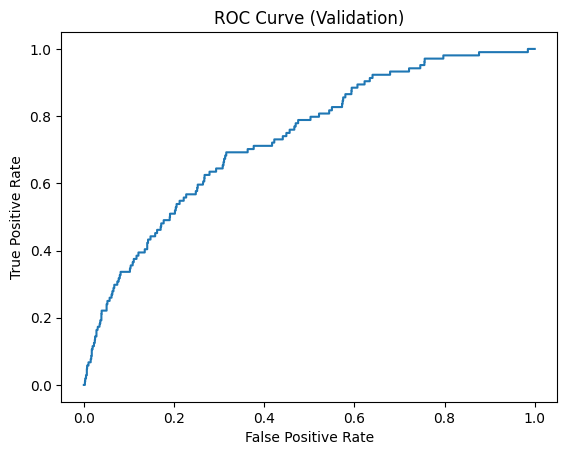

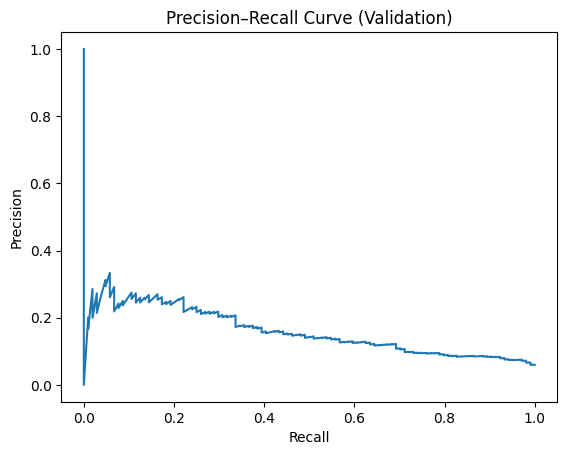

In [23]:
# 4) Curves (each in its own figure)
fpr, tpr, _ = roc_curve(y_val, proba_val)
plt.figure()
plt.plot(fpr, tpr)
plt.title("ROC Curve (Validation)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

precision, recall, _ = precision_recall_curve(y_val, proba_val)
plt.figure()
plt.plot(recall, precision)
plt.title("Precision–Recall Curve (Validation)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


ROC-AUC = 0.7429 Quality of ranking across all thresholds. 0.5 = random; 1.0 = perfect. This model meaningfully ranks likely buyers above non-buyers.

PR-AUC = 0.1591 Area under the Precision–Recall curve. Lens for imbalanced data (positives ≈ 6%). A naive baseline would be ≈ the positive rate (~0.06). 0.1591 ≫ 0.06 = good lift.

At the default threshold (0.5)

Confusion matrix TN=776 FP=319 FN= 23 TP= 47

Class 1 (buyers)

Recall = 0.67 (47/70): the model finds 67% of the actual buyers.

Precision = 0.13 (47/(47+319)): among predicted buyers, only 13% truly buy.

F1 = 0.22: harmonic mean of the two; low because precision is low.

Class 0 (non-buyers)

Precision = 0.97, Recall = 0.71, F1 ≈ 0.82 → model is strong at recognizing non-buyers.

Accuracy = 0.71 Not very informative under class imbalance (a “predict all 0s” model would already be ≈94% accurate here, so accuracy isn’t the right KPI).

Why precision is low @ 0.5: the dataset is highly imbalanced; using a 0.5 cut-off isn’t optimal for marketing targeting.

In [24]:
# 1) Define model (same settings as before, except C will be tuned)
base_logit = LogisticRegression(
    penalty="l2",
    class_weight="balanced",
    max_iter=2000,
    random_state=42
)

# 2) grid over C (inverse of regularization strength)
param_grid = {
    "C": [0.01, 0.1, 1.0, 3.0, 10.0]
}

# 3) 5-fold stratified CV, scored by PR-AUC (average precision)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=base_logit,
    param_grid=param_grid,
    scoring="average_precision",  # PR-AUC
    cv=cv,
    n_jobs=-1,
    refit=True,                   # refit on full training split with best params
    return_train_score=False
)

grid.fit(X_train_scaled, y_train)

print("Best params:", grid.best_params_)
print("Best CV PR-AUC:", round(grid.best_score_, 4))

best_logit = grid.best_estimator_

# 4) Evaluate best model on the validation split
proba_val = best_logit.predict_proba(X_val_scaled)[:, 1]
preds_val  = best_logit.predict(X_val_scaled)

results = evaluate_model("logistic regression (tuned) ", y_val, proba_val)

Best params: {'C': 0.01}
Best CV PR-AUC: 0.1563

=== logistic regression (tuned)  ===
ROC-AUC: 0.7491 | PR-AUC: 0.1787
Best-F1 threshold: 0.758
At best-F1: Precision=0.254, Recall=0.279, F1=0.266
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1643
           1       0.25      0.28      0.27       104

    accuracy                           0.91      1747
   macro avg       0.60      0.61      0.61      1747
weighted avg       0.91      0.91      0.91      1747



What we tuned: Only C (regularization strength). It’s the key lever for Logistic Regression.

Smaller C ⇒ stronger regularization (simpler model, less overfit).

Larger C ⇒ weaker regularization (more flexible model).

PR-AUC for scoring: Positives are rare (~6%). PR-AUC focuses on precision/recall trade-off, so improvements here are meaningful for our marketing use case.

Stratified 5-fold CV estimates generalization more robustly than a single split.